## Basic Collaborative Filtering of Movielens 100k Dataset

The dataset is 100k user ratings of movies. Given a user / movie pairt, predict a rating.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt

user_list = !whoami
username = user_list[0]
PATH = '/root/data/movielens/'

In [2]:
"""
Create a user and movie ID mapping
"""
import csv

# Tab delimited CSV with columns
# user id, item id, rating, timestamp.
DATA_FILE = f'{PATH}u.data'
DATA_LENGTH = 100 * 1000


class Mapping:
    def __init__(self):
        self.users = set()
        self.movies = set()
        with open(DATA_FILE, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            for user, movie, _, _ in reader:
                self.users.add(int(user))
                self.movies.add(int(movie))

        self.user_ids = {u: i for i, u in enumerate(self.users)}
        self.movie_ids = {m: i for i, m in enumerate(self.movies)}
                
    @property
    def num_movies(self):
        return len(self.movies)

    @property
    def num_users(self):
        return len(self.users)

    def get_movie_id(self, movie):
        return self.movie_ids[movie]

    def get_user_id(self, user):
        return self.user_ids[user]


In [3]:
"""
Define data loader
"""
import torch
from torch.utils.data import Dataset

TRAIN = 'TRAIN'
VALID = 'VALID'
TEST = 'TEST'
ALL = 'ALL'
SEGMENTS = {
    ALL: (0, DATA_LENGTH),
    TRAIN: (0, int(0.6 * DATA_LENGTH)),
    VALID: (int(0.6 * DATA_LENGTH), int(0.8 * DATA_LENGTH)),
    TEST: (int(0.8 * DATA_LENGTH), DATA_LENGTH)
}

class MovieRatingDataset(Dataset):
    def __init__(self, segment, mapping):
        self.mapping = mapping
        assert segment in SEGMENTS
        start, end = SEGMENTS[segment]
        ratings = []
        with open(DATA_FILE, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            for idx, row in enumerate(reader):
                if idx < start or idx >= end: continue
                # user id, item id, rating, timestamp.
                user, movie, rating, _ = row
                ratings.append([
                    self.mapping.get_user_id(int(user)),
                    self.mapping.get_movie_id(int(movie)),
                    int(rating)
                ])
                    
        self.ratings = torch.tensor(ratings)

    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.ratings[idx][:2], self.ratings[idx][2],

In [4]:
"""
Define linear model which learns embeddings
"""
import torch
import torch.nn as nn

MAX_RATING = 5.0
MIN_RATING = 1.0

def get_embed(num_items, num_features):
    embed = nn.Embedding(num_items, num_features)
    embed.weight.data.uniform_(-0.02, 0.02)
    return embed
    
class CollaborativeFilter(nn.Module):
    def __init__(self, num_users, num_movies, embed_size):
        super().__init__()
        self.user_embed = get_embed(num_users, embed_size)
        self.user_bias = get_embed(num_users, 1)
        self.movie_embed = get_embed(num_movies, embed_size)
        self.movie_bias = get_embed(num_movies, 1)
    
    def forward(self, inputs):
        users, movies = inputs[:, 0], inputs[:, 1]
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        linear = (
            (user_embeds * movie_embeds).sum(1) +
            self.user_bias(users).squeeze() +
            self.movie_bias(movies).squeeze() +
            MIN_RATING
        )
        return torch.sigmoid(linear) * (MAX_RATING - MIN_RATING) + MIN_RATING

In [31]:
"""
Define nonlinear model which learns embeddings then feeds
them into a neural network for regression.
"""
import torch
import torch.nn as nn

MAX_RATING = 5.0
MIN_RATING = 1.0


class CollabNet(nn.Module):
    def __init__(self, num_users, num_movies, embed_size):
        super().__init__()
        self.user_embed = get_embed(num_users, embed_size)
        self.movie_embed = get_embed(num_movies, embed_size)
        self.dense_1 = nn.Linear(2 * embed_size, 10)
        self.dense_2 = nn.Linear(10, 1)
        self.dropout_1 = nn.Dropout(p=0.05)
        self.dropout_2 = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        users, movies = inputs[:, 0], inputs[:, 1]
        embeds = torch.cat([self.user_embed(users), self.movie_embed(movies)], dim=1)
        acts = self.dropout_1(embeds)
        acts = self.dropout_2(self.relu(self.dense_1(acts)))
        acts = torch.sigmoid(self.dense_2(acts)) * (MAX_RATING - MIN_RATING) + MIN_RATING
        return acts.squeeze() 

In [32]:
"""
Load datasets
"""
mapping = Mapping()

train_ds = MovieRatingDataset(TRAIN, mapping)
valid_ds = MovieRatingDataset(VALID, mapping)
test_ds = MovieRatingDataset(TEST, mapping)


In [33]:
"""
Create data loaders, run training loop
"""
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from torch.utils.data import DataLoader

NUM_EPOCHS = 5
BATCH_SIZE = 64
EMBED_SIZE = 12
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-6

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
valid_dl = DataLoader(valid_ds, batch_size=1024, num_workers=3)

# Model = CollaborativeFilter
Model = CollabNet

net = Model(
    num_users=mapping.num_users,
    num_movies=mapping.num_movies,
    embed_size=EMBED_SIZE,

).cuda()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

train_loss_history = []
valid_loss_history = []
epoch_logs = []
itr = 0

for epoch in range(NUM_EPOCHS):    
    progress = tqdm(
        iterable=iter(train_dl),
        leave=False,
        desc=f'epoch {epoch + 1} / {NUM_EPOCHS}',
        total=len(train_dl),
        miniters=0
    )
    for inputs, ratings in progress:
        optimizer.zero_grad()
        outputs = net(inputs.cuda())
        outputs, ratings = outputs.cpu(), ratings.float()
        loss = criterion(outputs, ratings)
        loss.backward()
        loss_amount = loss.data.item()
        progress.set_postfix(loss=loss_amount, refresh=False)
        train_loss_history.append((itr, loss_amount))
        optimizer.step()            
        itr += 1
    
    # Get validation loss at the end of the epoch.
    batch_losses = []
    for inputs, ratings in valid_dl:
        outputs = net(inputs.cuda())
        loss = criterion(outputs.cpu(), ratings.float())
        batch_losses.append(loss.data.item())
    
    valid_loss_amount = sum(batch_losses) / float(len(batch_losses))
    valid_loss_history.append((itr, valid_loss_amount))

    print(
        f'epoch {epoch + 1} / {NUM_EPOCHS}, '
        f'loss: {loss_amount:0.3}, '
        f'valid loss: {valid_loss_amount:0.3f}'
    )
    progress.close()


epoch 1 / 5, loss: 1.49, valid loss: 1.138


epoch 2 / 5, loss: 0.864, valid loss: 0.979


epoch 3 / 5, loss: 0.883, valid loss: 0.966


epoch 4 / 5, loss: 0.836, valid loss: 0.952


epoch 5 / 5, loss: 0.827, valid loss: 0.953


Text(0, 0.5, 'Loss')

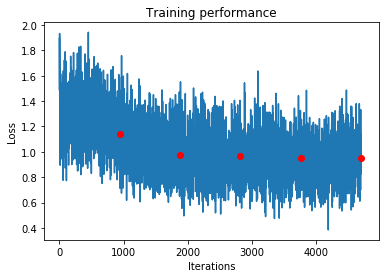

In [34]:
"""
Plot training loss, validation loss
"""
fig, ax = plt.subplots()
train_iters, train_loss = zip(*train_loss_history)
valid_iters, valid_loss = zip(*valid_loss_history)

ax.plot(train_iters, train_loss, label='train', zorder=0)
ax.scatter(valid_iters, valid_loss, label='valid', marker='o', c='red')
ax.set_title('Training performance')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

Random test loss is 2.86
Random test RMSE is 1.69

Average test loss is 0.98
Average test RMSE is 0.99



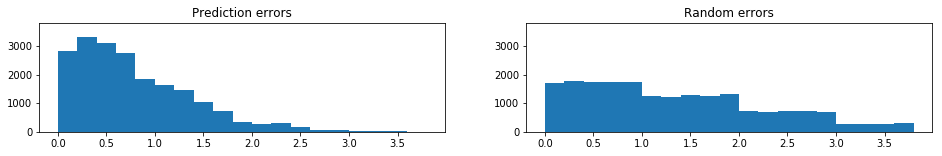

In [37]:
"""
Classify test dataset, check accuracy
"""
import math

test_dl = DataLoader(test_ds, batch_size=len(test_ds), num_workers=3)
inputs, ratings = next(iter(test_dl))
outputs = net(inputs.cuda())
outputs, ratings = outputs.cpu(), ratings.float()
random = torch.rand_like(outputs) * (MAX_RATING - MIN_RATING) + MIN_RATING
test_loss = criterion(outputs, ratings).data.item()
test_loss_random = criterion(random, ratings).data.item()
print(f'Random test loss is {test_loss_random:.2f}')
print(f'Random test RMSE is {math.sqrt(test_loss_random):.2f}\n')
print(f'Average test loss is {test_loss:.2f}')
print(f'Average test RMSE is {math.sqrt(test_loss):.2f}\n')

pred_errors = torch.abs(outputs - ratings).detach().numpy()
rand_errors = torch.abs(random - ratings).detach().numpy()

max_y = 3800
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2,))
bins = [0.2 * x for x in range(20)]
ax1.hist(x=pred_errors, bins=bins)
ax1.set_title('Prediction errors')
ax1.set_ylim([0, max_y])
ax2.hist(x=rand_errors, bins=bins)
ax2.set_title('Random errors')
ax2.set_ylim([0, max_y])
fig.subplots_adjust(hspace=0.3)